# Loading the dataset

/tmp/ipykernel_745253/1026210245.py:17: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  Q = (nominal_Q * initial_SOC) - cumtrapz(df['bat_i'], df['t'], initial=0) / seconds_in_one_hour  # units: Amper-hour


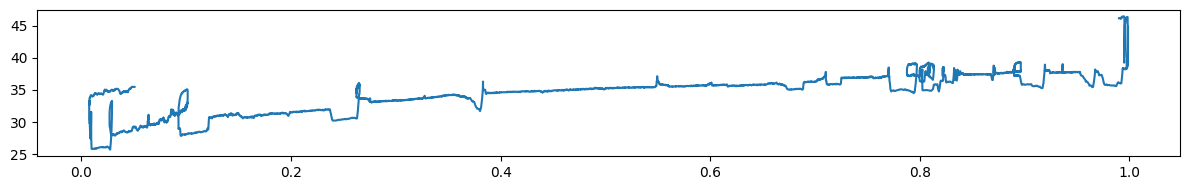

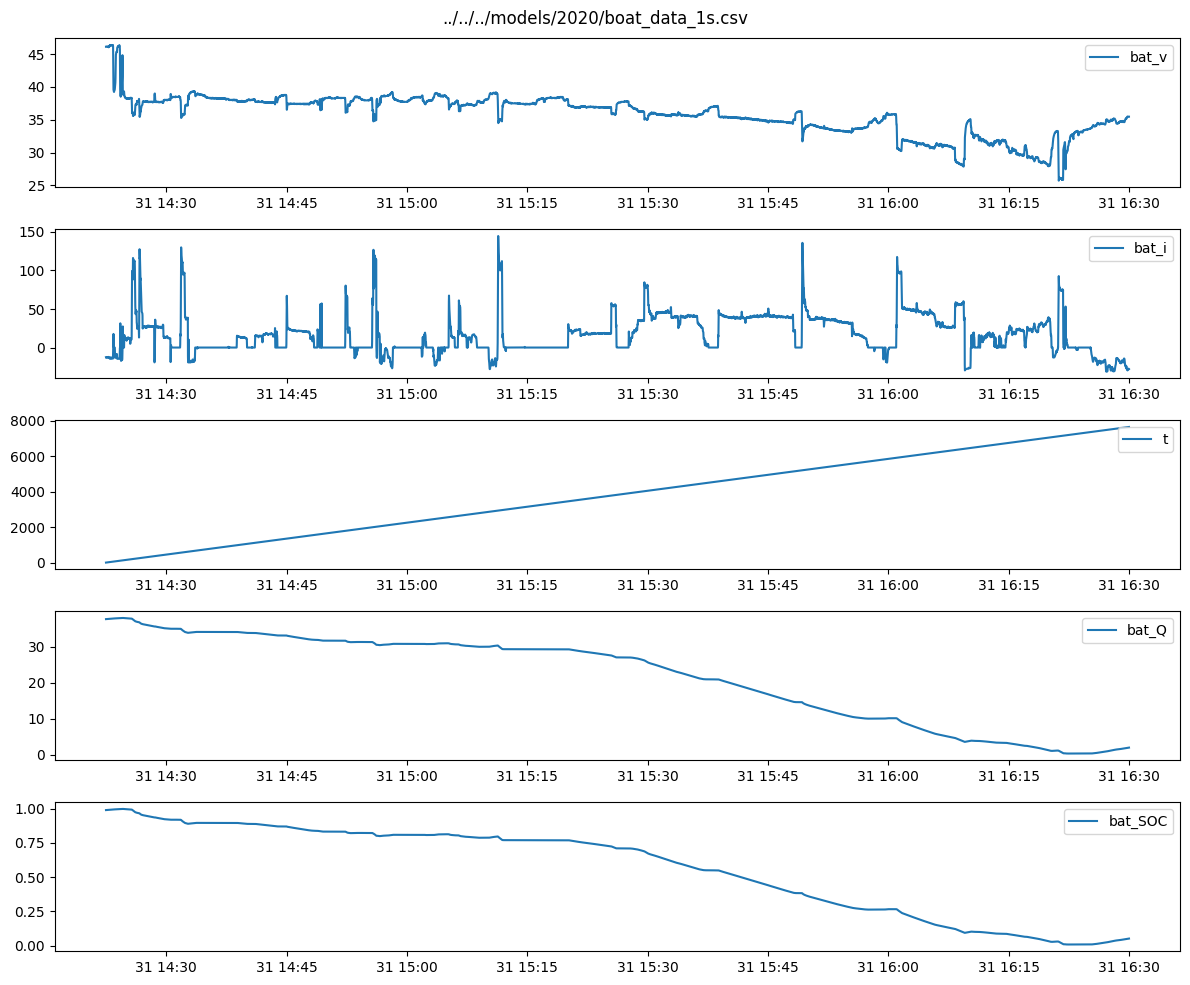

,bat_v,bat_i,t,bat_Q,bat_SOC
count,7651.000000,7651.000000,7651.000000,7651.000000,7651.000000
mean,35.764849,16.791291,3825.000000,21.491337,0.565561
std,2.998944,24.502781,2208.797788,12.143724,0.319572
min,25.710004,-31.234375,0.000000,0.282155,0.007425
25%,34.179625,0.000000,1912.500000,10.064163,0.264846
50%,36.664047,13.676682,3825.000000,26.989866,0.710260
75%,37.868615,34.621357,5737.500000,31.267359,0.822825
max,46.375878,144.744320,7650.000000,37.950804,0.998705


nans:  0


,bat_v,bat_i,t,bat_Q,bat_SOC
timestamp,,,,,
2020-01-31 14:22:30,46.112379,-12.441707,0.0,37.620000,0.990000
2020-01-31 14:22:31,46.112379,-12.379807,1.0,37.623447,0.990091
2020-01-31 14:22:32,46.112379,-12.891741,2.0,37.626957,0.990183
2020-01-31 14:22:33,46.112379,-13.238582,3.0,37.630587,0.990279
2020-01-31 14:22:34,46.150022,-13.183948,4.0,37.634256,0.990375
...,...,...,...,...,...
2020-01-31 16:29:56,35.459478,-27.599330,7646.0,1.897524,0.049935
2020-01-31 16:29:57,35.459478,-27.582933,7647.0,1.905188,0.050137
2020-01-31 16:29:58,35.459478,-27.481535,7648.0,1.912836,0.050338


In [17]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import cumtrapz
import numpy as np
import vaex
from pytz import timezone

def compute_df_soc(df, nominal_Q, inplace=False):
    SOC = df['bat_Q'].to_numpy() / nominal_Q

    if inplace:
        df['bat_SOC'] = SOC
    return SOC

def compute_df_capacity(df, nominal_Q, initial_SOC, inplace=False):
    seconds_in_one_hour = 3600.0
    Q = (nominal_Q * initial_SOC) - cumtrapz(df['bat_i'], df['t'], initial=0) / seconds_in_one_hour  # units: Amper-hour

    if inplace:
        df['bat_Q'] = Q
    return Q

def load_df(filename, start, end, nominal_Q, initial_SOC, resample_rule='1s', rename_columns={}):
    df = vaex.from_csv(filename).to_pandas_df()
    df["timestamp"] = pd.DatetimeIndex(df["timestamp"]).tz_convert(None)
    df = df.set_index("timestamp", drop=True)

    df = df.loc[
        (df.index >= start) & (df.index <= end),
        rename_columns.keys(),
    ].rename(columns=rename_columns).resample(resample_rule).mean().interpolate(method='time', limit_area='inside')

    # After resampling, create the equally-spaced 't' index, used for control simulations
    df['t'] = df.index.to_numpy(dtype='timedelta64[s]').astype(float) * 1e-9  # t is now a float in seconds
    df['t'] -= df['t'].iloc[0]

    compute_df_capacity(df, nominal_Q, initial_SOC, inplace=True)
    compute_df_soc(df, nominal_Q, inplace=True)

    return df

cell_amps_hour = 38
series_cells = 3
parallel_cells = 1
cell_voltage = 12
nominal_Q = parallel_cells * cell_amps_hour  # Capacity, in Amper-hour
initial_SOC = 0.99
nominal_E = series_cells * parallel_cells * cell_amps_hour * cell_voltage

# From Revezamento
tzinfo = timezone("America/Sao_Paulo")

start = pd.Timestamp(
    year=2020, month=1, day=31, hour=11, minute=22, second=30, tzinfo=tzinfo
).tz_convert(None)
end = pd.Timestamp(
    year=2020, month=1, day=31, hour=13, minute=30, second=0, tzinfo=tzinfo
).tz_convert(None)

filename = "../../../models/2020/boat_data_1s.csv"
rename_columns = {
    'Battery Pack Voltage': 'bat_v',
    'Battery Current': 'bat_i',
}
df = load_df(filename, start, end, resample_rule='1s', rename_columns=rename_columns, nominal_Q=nominal_Q, initial_SOC=initial_SOC)

plt.figure(figsize=(12, 2))
plt.plot(df['bat_SOC'], df['bat_v'])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(len(df.columns), figsize=(12,10))
for k, col in enumerate(df.columns):
    ax[k].plot(df.index, df[col], label=col)
    ax[k].legend(loc=1)

plt.suptitle(filename)
plt.tight_layout()
plt.show()

display(df.describe())

# Check for nans in the data
print('nans: ', df.isna().sum().sum())

df

# Battery Equivalent Circuit Model

![](feZkCLr.png)

As seguintes equações representam o sistema da imagem acima, onde $z(t)$ é o estado de carga da bateria:

$$ \begin{aligned}
    \frac{di_{R_{1}}(t)}{dt} &= 
        -\frac{1}{R_{1} C_{1}} i_{R_{1}}(t) 
        +\frac{1}{R_{1} C_{1}} i(t) \\
    v(t) &= 
        -R_{1} i_{R_{1}}(t) 
        -R_{0} i(t) 
        +OCV(z(t)) 
\end{aligned} $$

O estado de carga ($z(t)$) pode ser definido como nas equações abaixo, onde $Q$ é a carga nominal da bateria, e $\eta$, a eficiência culombica:

$$ \begin{aligned}
    z(t) &= 
        z(t_{0}) 
        -\frac{1}{Q} \int_{t_{0}}^t \eta(t) i(t) dt \\
    \frac{dz(t)}{dt} &= 
        -\frac{\eta(t) i(t)}{Q}
\end{aligned} $$

Para que possam ser utilizadas os métodos de solução de sistemas no espaço de estados, podemos separar $VOC(z(t))$ em um modelo externo, considerando-o como uma entrada, deste modo, a função $VOC(z(t))$ pode ser um modelo caixa-preta.

<!-- $$ \begin{aligned}
    VOC(z(t)) &= 
        \sum_{i=0}^{7}\left(c_{i} z^{i}(t)\right) 
        +c_{8} e^{c_{9} z(t)}
\end{aligned} $$ -->

Considerando os estados $X$, entrada $U$ e saídas $Y$:

$$ \begin{aligned}
    X &= 
        \begin{bmatrix}
            i_{R_{1}}(t) \\
            z(t)
        \end{bmatrix} \\
    Y &= 
        \begin{bmatrix}
            v(t) \\
            z(t)
        \end{bmatrix} \\
    U &= 
        \begin{bmatrix}
            i(t) \\
            VOC(z(t))
        \end{bmatrix}
\end{aligned} $$

Considerando a representação no espaço de estados como:

$$ \begin{aligned}
    \dot{X} &= AX + BU \\
    Y &= CX + DU
\end{aligned} $$

As equações do circuito pode ser re-escritas como:

$$ \begin{aligned}
    \dot{X_{0}} &= 
        -\frac{1}{R_{1} C_{1}} X_{0}
        +\frac{1}{R_{1} C_{1}} U_{0} \\
    Y_{0} &= 
        -R_{1} X_{0}
        -R_{0} U_{0}
        +U_{1}
\end{aligned} $$

Enquanto as equações da relação do estado de carga, considerando uma eficiencia culombica $\eta$ constante, ficam:

$$ \begin{aligned}
    \dot{X_{1}} &= 
        -\frac{\eta}{Q} U_{0} \\
    Y_{1} &=
        X_{1}
\end{aligned} $$

Logo, as matrizes do Espaço de Estados são:

$$ \begin{aligned}
    A &= 
        \begin{bmatrix}
            -\frac{1}{R_{1} C_{1}}    & 0 \\
            0                         & 0
        \end{bmatrix} \\
    B &= 
        \begin{bmatrix}
            \frac{1}{R_{1} C_{1}}     & 0 \\
            -\frac{\eta}{Q}           & 0
        \end{bmatrix} \\
    C &= 
        \begin{bmatrix}
            -R_{1}    & 0 \\
            0         & 1
        \end{bmatrix} \\
    D &= 
        \begin{bmatrix}
            -R_{0}    & 0 \\
            0         & 0
        \end{bmatrix}
\end{aligned} $$

In [18]:
import control as ct

# ref: https://books.google.com.br/books?id=suLRCgAAQBAJ&pg=PA29&hl=pt-BR&source=gbs_toc_r&cad=2#v=onepage&q&f=false
class BatteryLinearPart:
    @classmethod
    def build(cls, params: dict):
        # Get the parameter values
        R_0 = params['bat_R_0']
        R_1 = params['bat_R_1']
        C_1 = params['bat_C_1']
        Q = params['bat_Q']
        eta = params['bat_eta']

        # From:
        #   di_R1(t)/dt = (-i_R1(t) + i(t))*(1/(R1*C1))
        #   dz(t)/dt = -eta*i(t)/Q
        #   v(t) = -R1*i_R1(t) -R0*i(t) + OCV(Z(t))

        # State Transition matrix, shape 'n,n' -> '2x2'
        A = np.array([
            [-1 / (R_1 * C_1), 0],
            [0,                0]
        ])

        # Input matrix, shape 'n,m' -> '2x2'
        B = np.array([
            [+1 / (R_1 * C_1), 0],
            [-eta / Q,         0]
        ])

        # Output matrix, shape 'p,n' -> '2x2'
        C = np.array([
            [-R_1, 0],
            [0,    1]
        ])

        # Remaining matrix, shape 'p,m' -> '2x2'
        D = np.array([
            [-R_0, 1],
            [0,    0]
        ])

        return ct.ss(
            A,
            B,
            C,
            D,
            name='battery_linear_part',
            states=('I_R1', 'SOC'),
            inputs=('I', 'VOC'),
            outputs=('V', 'SOC'),
        )

class BatteryNonLinearPart:
    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Get the parameter values
        coeffs = params['bat_coeffs']

        # Get the inputs
        SOC = u[0]

        # Compute the OCV(SOC(t))
        return np.polynomial.Polynomial(coeffs)(SOC)

    @classmethod
    def build(cls, params: dict):
        return ct.NonlinearIOSystem(
            None,
            cls._outputs,
            name='battery_nonlinear_part',
            states=None,
            inputs='SOC',
            outputs='VOC',
            params=params,
        )

class Battery:
    @classmethod
    def build(cls, params: dict):
        return ct.interconnect(
            (
                BatteryLinearPart.build(params),
                BatteryNonLinearPart.build(params),
            ),
            name='battery',
            connections=(
                ('battery_linear_part.VOC', 'battery_nonlinear_part.VOC'),
                ('battery_nonlinear_part.SOC', 'battery_linear_part.SOC'),
            ),
            inplist=('battery_linear_part.I'),
            inputs=('I',),
            outlist=('battery_linear_part.V', 'battery_linear_part.SOC'),
            outputs=('V', 'SOC'),
        )


Battery.build({
    'bat_Q': nominal_Q,
    'bat_eta': 1,
    'bat_R_0': 0.04,
    'bat_R_1': 0.01,
    'bat_C_1': 10,
    'bat_coeffs': [0, 10, 15, 0],
})

<InterconnectedSystem:battery:['I']->['V', 'SOC']>

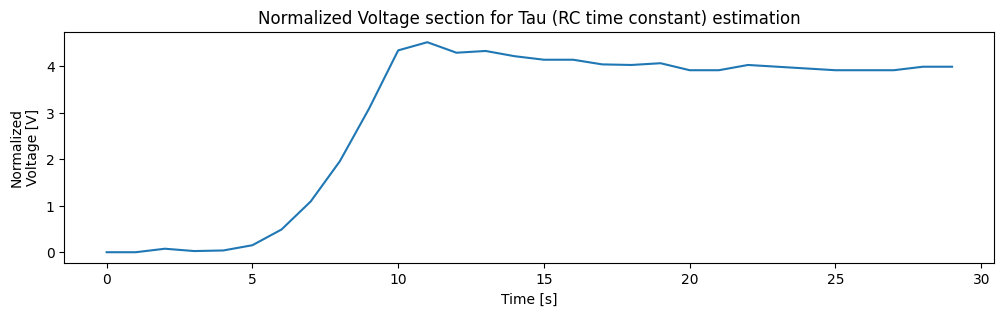

{'rise_time': 4.0,
 'settling_time': 17.0,
 'settling_min': 3.9148468673229146,
 'settling_max': 4.51713100075721,
 'peak_value': 4.51713100075721,
 'peak_time': 11.0,
 'undershoot': 0,
 'overshoot': 13.207547169811344,
 'steady_state_value': 3.9901323840022016,
 'estimated_tau': 1.8181818181818181}

In [19]:
def find_peak_info(T, yout, SettlingTimeThreshold = 0.02, RiseTimeLimits = (0.1, 0.9)):
    # Steady state value
    InfValue = yout[-1]
    sgnInf = np.sign(InfValue.real)

    rise_time: float = np.NaN
    settling_time: float = np.NaN
    settling_min: float = np.NaN
    settling_max: float = np.NaN
    peak_value: float = np.Inf
    peak_time: float = np.Inf
    undershoot: float = np.NaN
    overshoot: float = np.NaN
    steady_state_value: complex = np.NaN

    if not np.isnan(InfValue) and not np.isinf(InfValue):
        # RiseTime
        tr_lower_index = np.where(
            sgnInf * (yout - RiseTimeLimits[0] * InfValue) >= 0
            )[0][0]
        tr_upper_index = np.where(
            sgnInf * (yout - RiseTimeLimits[1] * InfValue) >= 0
            )[0][0]
        rise_time = T[tr_upper_index] - T[tr_lower_index]

        # SettlingTime
        settled = np.where(
            np.abs(yout/InfValue-1) >= SettlingTimeThreshold)[0][-1]+1
        # MIMO systems can have unsettled channels without infinite
        # InfValue
        if settled < len(T):
            settling_time = T[settled]

        settling_min = min((yout[tr_upper_index:]).min(), InfValue)
        settling_max = max((yout[tr_upper_index:]).max(), InfValue)

        # Overshoot
        y_os = (sgnInf * yout).max()
        dy_os = np.abs(y_os) - np.abs(InfValue)
        overshoot = np.abs(100. * dy_os / InfValue) if dy_os > 0 else 0

        # Undershoot : InfValue and undershoot must have opposite sign
        y_us_index = (sgnInf * yout).argmin()
        y_us = yout[y_us_index]
        undershoot = (-100. * y_us / InfValue) if (sgnInf * y_us) < 0 else 0

        # Peak
        peak_index = np.abs(yout).argmax()
        peak_value = np.abs(yout[peak_index])
        peak_time = T[peak_index]

        # SteadyStateValue
        steady_state_value = InfValue

    return {
        'rise_time': rise_time,
        'settling_time': settling_time,
        'settling_min': settling_min,
        'settling_max': settling_max,
        'peak_value': peak_value,
        'peak_time': peak_time,
        'undershoot': undershoot,
        'overshoot': overshoot,
        'steady_state_value': steady_state_value,
    }

k = df['bat_i'].argmax()
df_a = df.copy(deep=True).iloc[k-10:k+20]

yout = df_a['bat_v'].to_numpy()
yout -= yout[0]
yout *= -1
T = df_a['t'].to_numpy()
T -= T[0]

plt.figure(figsize=(12,3))
plt.plot(T, yout)
plt.xlabel('Time [s]')
plt.ylabel('Normalized\nVoltage [V]')
plt.title('Normalized Voltage section for Tau (RC time constant) estimation')
plt.show()

peak_info = find_peak_info(T, yout)
peak_info['estimated_tau'] = peak_info['rise_time'] / 2.2
peak_info

# Optimization

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.6662e+06                                    8.74e+11    
       1              2         4.5948e+06      7.14e+04       6.75e-05       5.26e+12    
       2              6         4.5948e+06      0.00e+00       0.00e+00       5.26e+12    
`xtol` termination condition is satisfied.
Function evaluations 6, initial cost 4.6662e+06, final cost 4.5948e+06, first-order optimality 5.26e+12.


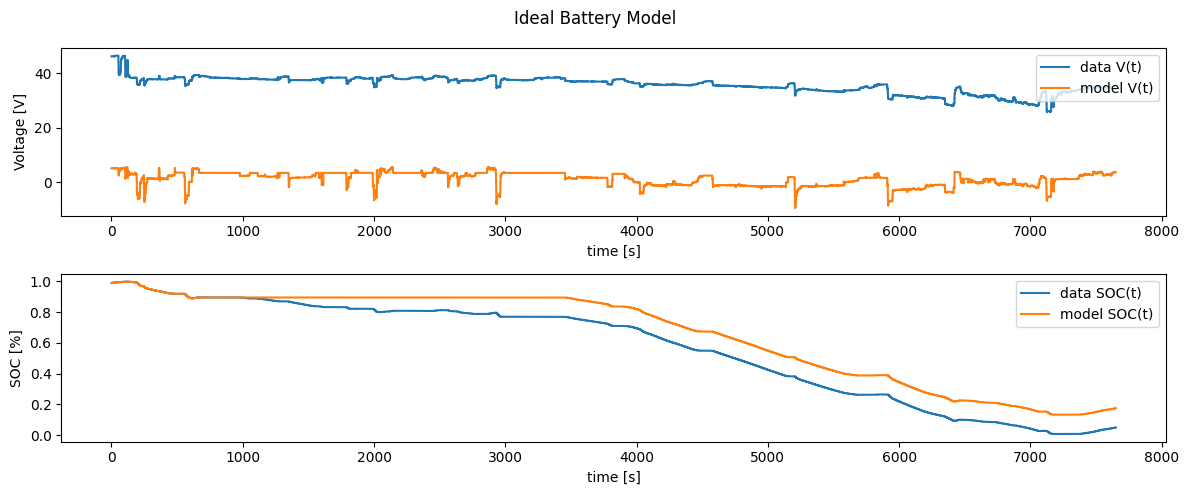

In [24]:
import lmfit

def convert_params(params):
    n_coeffs = sum(1 for k in params if k.startswith('bat_coeff_'))
    return {
        'bat_eta': params['bat_eta'],
        'bat_Q': params['bat_Q'],
        'bat_R_0': params['bat_R_0'],
        'bat_R_1': params['bat_R_1'],
        'bat_C_1': params['bat_C_1'],
        'bat_coeffs': [params[f'bat_coeff_{i}'] for i in range(n_coeffs - 1)],
    }

def func(T, U, X0, **params):
    # Simulate the system response
    return ct.input_output_response(Battery.build(convert_params(params)), T=T, U=U, X0=X0, solve_ivp_kwargs={'method': 'Radau'}).to_pandas()[['V', 'SOC']].to_numpy()

# RECORD EVERY STEP
global_residuals = []
global_iters = []
global_params = []
def iter_cb(params, iter, resid, *fcn_args, **fcn_kws):
    global global_residuals
    global global_iters
    global global_params

    global_residuals += [resid]
    global_iters += [iter]
    global_params += [params.valuesdict()]


# Initial parameters
initial_eta = 1.0
initial_R_0 = (df['bat_v'].iloc[0] - df['bat_v'].loc[df['bat_i'].idxmax()]) / df['bat_i'].max()
initial_R_1 = initial_R_0 / 10
initial_tau = peak_info['estimated_tau'] / 10
max_tau = initial_tau * 10
min_tau = initial_tau / 10
initial_C_1 = initial_tau / initial_R_1
initial_coeffs = np.ones(5)

# Create lmfit Parameters object and set initial guesses
params = lmfit.Parameters()
params.add('bat_eta', value=initial_eta, min=0.5, max=1, vary=False)
params.add('bat_Q', value=nominal_Q * 3600, vary=False)  # Ampere-seconds
params.add('bat_R_0', value=initial_R_0, min=1e-6, max=1e+0, vary=True)
params.add('bat_R_1', value=initial_R_1, min=1e-6, max=1e+0, vary=True)
params.add('bat_C_1', value=initial_C_1, min=1e+0, max=1e6, vary=True)
# params.add('bat_tau_constraint', value=initial_R_1 * initial_C_1, min=min_tau, max=max_tau, expr='bat_R_1 * bat_C_1') # This enforces R1 and C1 limits to respect Tau
for i in range(0, len(initial_coeffs)):
    params.add(f'bat_coeff_{i}', value=initial_coeffs[i], min=-1e6, max=1e6, vary=(True))

model = lmfit.Model(func=func, independent_vars=['T', 'U', 'X0'])

## Define data to fit
data = df[['bat_v', 'bat_SOC']]

# Input data
T = (df['t'] - df['t'].iloc[0]).to_numpy()  # simulation time in seconds
U = df['bat_i'].to_numpy()
dt = df['t'].iloc[1] - df['t'].iloc[0]
X0 = [
    df['bat_i'].iloc[0],
    df['bat_SOC'].iloc[0] - df['bat_i'].iloc[0] * (dt * params['bat_eta'] / params['bat_Q']),
]

# Optimize
result = model.fit(
    data=data,
    params=params,
    iter_cb=iter_cb,
    T=T,
    U=U,
    X0=X0,
    method='least_squares',
    fit_kws=dict( # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html
        verbose=2,
    )
)

## Test/Plot
if True:

    # Test
    battery = Battery.build(convert_params(result.params.valuesdict()))

    df_out = ct.input_output_response(
        battery,
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method='Radau',
    ).to_pandas()

    fig, ax = plt.subplots(2, figsize=(12, 5))
    ax[0].step(df['t'], df['bat_v'], label='data V(t)')
    ax[0].step(df['t'], df_out['V'], label='model V(t)')
    ax[0].set_xlabel('time [s]')
    ax[0].set_ylabel('Voltage [V]')
    ax[0].legend(loc=1)

    ax[1].step(df['t'], df['bat_SOC'], label='data SOC(t)')
    ax[1].step(df['t'], df_out['SOC'], label='model SOC(t)')
    ax[1].set_xlabel('time [s]')
    ax[1].set_ylabel('SOC [%]')
    ax[1].legend(loc=1)

    plt.suptitle('Ideal Battery Model')
    plt.tight_layout()
    plt.show()


## Print the optimization report
display(result)

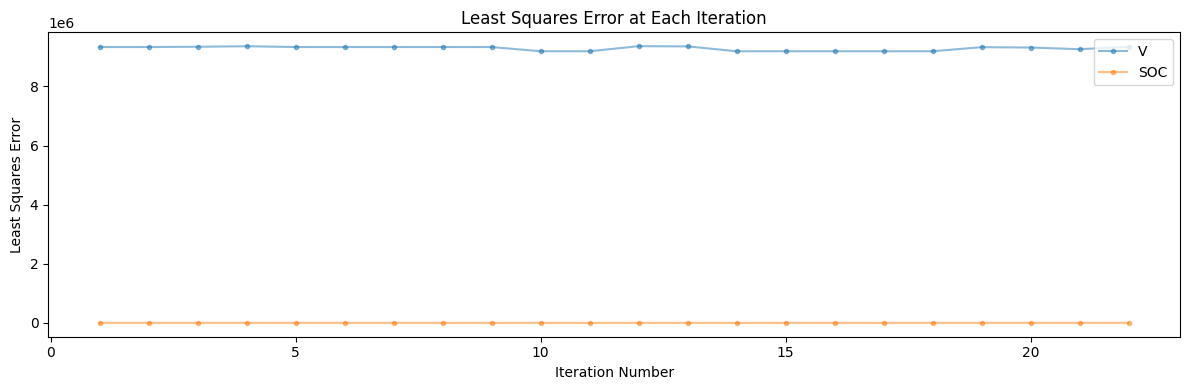

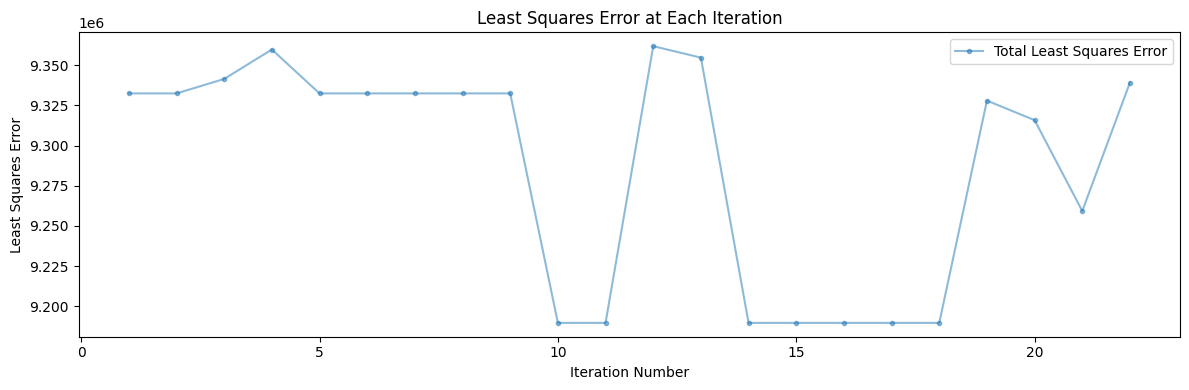

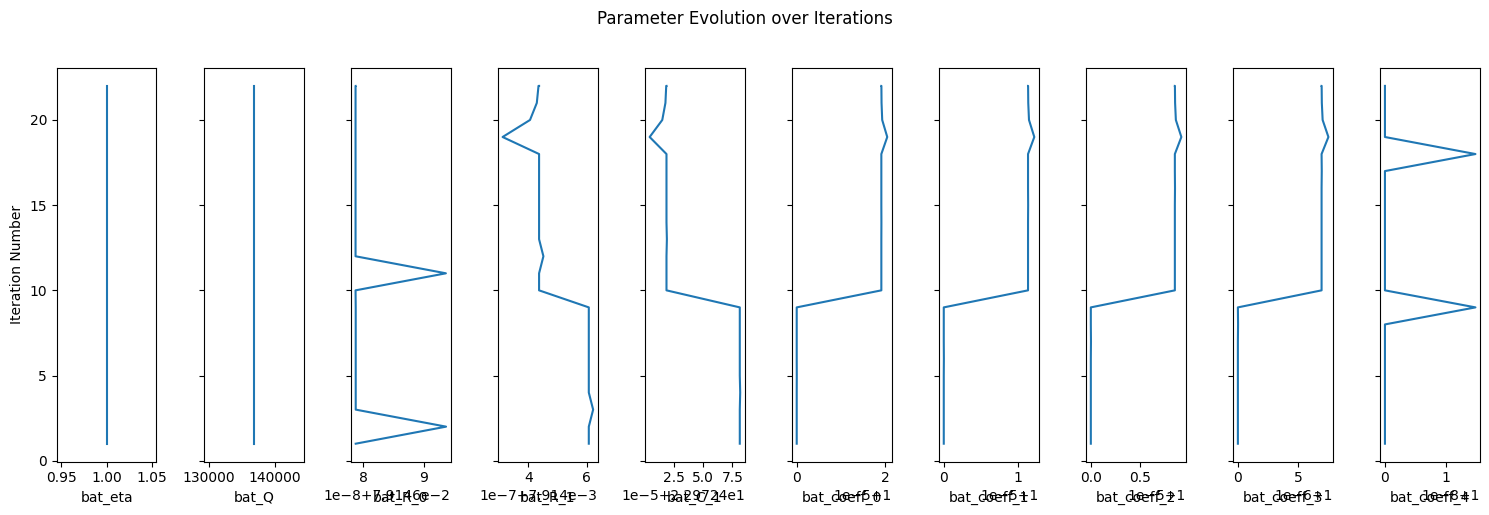

In [21]:
least_squares_errors = [np.sum(np.square(residual), axis=0) for residual in global_residuals]

plt.figure(figsize=(12 ,4))
plt.plot(global_iters[:-1], np.array(least_squares_errors)[:-1,0].T, marker='.', linestyle='-', alpha=0.5, label=battery.output_labels[0])
plt.plot(global_iters[:-1], np.array(least_squares_errors)[:-1,1].T, marker='.', linestyle='-', alpha=0.5, label=battery.output_labels[1])
plt.title('Least Squares Error at Each Iteration')
plt.xlabel('Iteration Number')
plt.ylabel('Least Squares Error')
plt.legend(loc=1)
plt.tight_layout()
plt.show()

least_squares_errors_total = [np.sum(np.square(residual.flatten())) for residual in global_residuals]

plt.figure(figsize=(12, 4))
plt.plot(global_iters[:-1], np.array(least_squares_errors_total)[:-1].T, marker='.', linestyle='-', alpha=0.5, label='Total Least Squares Error')
plt.title('Least Squares Error at Each Iteration')
plt.xlabel('Iteration Number')
plt.ylabel('Least Squares Error')
plt.legend(loc=1)
plt.tight_layout()
plt.show()

param_names = list(global_params[0].keys())  # Assuming all steps have the same parameters

fig, axs = plt.subplots(1, len(param_names), figsize=(1.5 * len(param_names), 5), sharey=True)
# Plot each parameter value over iterations in a separate subplot
for i, param_name in enumerate(param_names):
    param_values = [step[param_name] for step in global_params]
    axs[i].plot(param_values, global_iters, label=param_name)
    axs[i].set_xlabel(param_name)
axs[0].set_ylabel('Iteration Number')
plt.suptitle('Parameter Evolution over Iterations', y=1.02)
plt.tight_layout()
plt.show()

In [22]:
display(result.params.valuesdict())

# Best:
{'bat_eta': 1.0,
 'bat_Q': 410400,
 'bat_R_0': 0.03985240854754133,
 'bat_R_1': 0.007914487548258303,
 'bat_C_1': 22.972482881066735,
 'bat_tau_constraint': 0.1818154297147797,
 'bat_coeff_0': -35.496525229630485,
 'bat_coeff_1': 222.19569278746164,
 'bat_coeff_2': -236.08184096117012,
 'bat_coeff_3': 90.62137416447962,
 'bat_coeff_4': 1.0}

{'bat_eta': 1.0,
 'bat_Q': 136800,
 'bat_R_0': 0.07914607876623743,
 'bat_R_1': 0.007914436887448688,
 'bat_C_1': 22.972418538514045,
 'bat_coeff_0': 1.0000191547516037,
 'bat_coeff_1': 1.000011366332212,
 'bat_coeff_2': 1.000008567299883,
 'bat_coeff_3': 1.0000069152511042,
 'bat_coeff_4': 1.0}

{'bat_eta': 1.0,
 'bat_Q': 410400,
 'bat_R_0': 0.03985240854754133,
 'bat_R_1': 0.007914487548258303,
 'bat_C_1': 22.972482881066735,
 'bat_tau_constraint': 0.1818154297147797,
 'bat_coeff_0': -35.496525229630485,
 'bat_coeff_1': 222.19569278746164,
 'bat_coeff_2': -236.08184096117012,
 'bat_coeff_3': 90.62137416447962,
 'bat_coeff_4': 1.0}